In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import sqrtm
from sklearn.linear_model import ElasticNet

from saddle_point.experiments.learning_curve import LearningCurve
from saddle_point.experiments.cluster import ClusterExperiment

# Classification of $K=2$ Gaussian clusters with nonhomogeneous covariances

This notebook consider the problem of classification on a mixture of two Gaussian clusters with opposite means $\boldsymbol\mu_1=-\boldsymbol\mu_2\equiv\boldsymbol\mu$ and nonhomegenous covariances, i.e., covariances in the form $\boldsymbol\Sigma=\mathrm{diag}(\sigma_j)\in\mathbb R^{d\times d}$. The covariances are such that each $\sigma_j$ follows the distribution
$$P(\sigma)=\sum_{r=1}^Rp_r\delta(\sigma-\Delta_r),\qquad \mathbf p=(p_r)_r$$
where $\boldsymbol\Delta=(\Delta_r)_r$ is a set of $R$ prefixed values. We also consider two settings for the means of the clusters:
- in the 'dense' setting, the means have Gaussian entries of zero mean and unit variance.
- in the 'sparse' setting we impose $R=2$ and we generate means and variances in a correlated way, and in particular we use
$$ P(\boldsymbol\mu,\boldsymbol\sigma)=\prod\limits_{i=1}^{d}\left\{\rho \mathcal{N}(\mu_{i}|0,1) \delta_{\sigma_{i}, \Delta_{2}} + (1-\rho) \delta_{\mu_{i},0} \delta_{\sigma_{i}, \Delta_{1}}\right\}$$

To obtain the theoretical prediction for this setting, it is possible to first create an object ```MyPredictor``` of type ```LearningCurve```, class in ```saddle_point.experiments.learning_curve```.The creation of such object requires some input parameters:
- ```loss```. At the moment, the code allows to analyse this problem using two different losses,
    - Square loss $\ell(z) = \frac{1}{2}(1-z)^2$, using ```loss='square'```
    - Logistic loss $\ell(z) = \log\left(1-e^{-z}\right)$ using ```loss='log'```
- ```penalty```, corresponding to the type of regularisation. The code also support two possible regularisation, namely $\ell_1$ using ```penalty='l1'``` and $\ell_2$ using ```penalty='l2'```.
- ```regularisation```, a float number corresponding to the strength $\lambda$ of the regularisation.
- ```variances```, a vector corresponding to the set $\boldsymbol \sigma$.
- ```ratios```, corresponding to the vector $\mathbf p$. *In the case in which we select a the ```'sparse'``` model this has to be a scalar!*
- ```probability```, a scalar corrisponding to the relative weight $\rho$ between the two clusters.
- ```damping```, strength of the damping in the saddle-point iterations.
- ```berbose```, boolean, ```True``` if want to print the progress, ```False``` otherwise. 
- ```problem```, option to specify if we want sparse or dense means.

Once ```MyPredictor``` is created, it is possible tu run the for different values of the sample complexity, e.g., calling ```MyPredictor.learning_curve(sc_range = np.linspace(0.01, 3, 100))``` to obtain the learning curves between sample complexity 0.01 and sample complexity 3 with 100 steps. For example

In [102]:
loss = 'square'
penalty = 'l1'
regularisation = 0.1
variances = [0.1, 1]
ratios = 0.5
probability = 0.5
damping=0.9
problem = 'sparse'
MyPredictor = LearningCurve(loss = loss,
                            penalty = penalty, 
                            regularisation = regularisation, 
                            variances = variances,
                            ratios = ratios,
                            probability = probability,
                            damping = damping,
                            verbose = False,
                            problem = problem)
MyPredictor.learning_curve(sc_range = np.linspace(0.01, 2, 200))

To get the output we run now

In [103]:
MyPredictor.get_curve()

,loss,penalty,lambda,probability,sample_complexity,V,m,q,b,test_error,train_loss
0,square,l1,0.1,0.5,0.01,1.663956,1.963673e-13,0.137356,0.0,0.500000,0.080133
1,square,l1,0.1,0.5,0.02,2.386886,6.738119e-10,0.190821,0.0,0.500000,0.051906
2,square,l1,0.1,0.5,0.03,2.860255,6.051796e-08,0.229770,0.0,0.500000,0.041263
3,square,l1,0.1,0.5,0.04,3.210359,1.215748e-06,0.262614,0.0,0.499999,0.035612
4,square,l1,0.1,0.5,0.05,3.484143,1.083718e-05,0.292102,0.0,0.499992,0.032129
...,...,...,...,...,...,...,...,...,...,...,...
195,square,l1,0.1,0.5,1.96,0.650698,7.848443e-01,0.209576,0.0,0.043227,0.046952
196,square,l1,0.1,0.5,1.97,0.646751,7.851753e-01,0.209261,0.0,0.043043,0.047093
197,square,l1,0.1,0.5,1.98,0.642848,7.855021e-01,0.208949,0.0,0.042861,0.047233
198,square,l1,0.1,0.5,1.99,0.638988,7.858248e-01,0.208640,0.0,0.042681,0.047372


We can plot our curves in the usual way

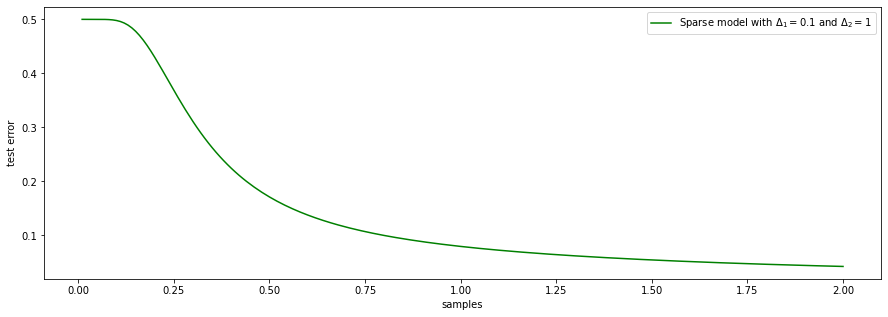

In [104]:
fig, ax = plt.subplots(figsize=(15,5))
if(problem == 'sparse'):
    label = 'Sparse model with $\Delta_1=${} and $\Delta_2=${}'.format(variances[0],variances[1])
else:
    label = 'Dense mean with $\boldsymbol\sigma=${} and $\mathbf p=${}'.format(variances,ratios)

ax=MyPredictor.get_curve().plot(x='sample_complexity', 
        y='test_error', 
        ax=ax, color='green',
        label=label)
plt.ylabel(r"test error")
plt.xlabel(r"samples")
plt.legend()

### An example of comparison with numerical experiments

Let us consider the setting given by the options

In [95]:
loss = 'square'
penalty = 'l1'
regularisation = 0.1
variances = [0.1, 1]
ratios = 0.5
probability = 0.5
problem = 'sparse'
d=500

Here ```d=500``` is the dimension we want to use for our experiment. Let us compare our theoretical prediction with numerical experiments. We can implement our solver first giving a function that generate our samples.

In [96]:
def get_meancov(d=500, *, ρ, Δ0, Δ1):
    mean = np.random.normal(0, 1, d) / np.sqrt(d)
    idx = np.random.choice(d, size=int((1-ρ)*d), replace=False)
    cov = Δ1 * np.identity(d)
    sqrtcov = np.sqrt(Δ1) * np.identity(d)
    cov[idx, idx] = Δ0
    sqrtcov[idx, idx] = np.sqrt(Δ0)
    mean[idx] = 0.
    return mean, cov, sqrtcov

In [97]:
def get_samples(*, n, mean, sqrtcov, prob):
    y = np.random.choice([1,-1], n, p = [prob, 1-prob])
    X = y.reshape(n,1) @ mean.reshape(1,d) + np.random.normal(0,1,(n,d)) @ sqrtcov.T
    return X/np.sqrt(d), y

Then, we implement a function to get averaged training and test error over a number of seeds for a fixed number of samples ```seeds```.

In [98]:
def get_errors(*, samples, p, λ, seeds, Δ0, Δ1, ρ, penalty):
    eg, et, q_tab, m_tab, b_tab = [], [], [], [], []
    for i in range(seeds):
        mean, cov, sqrtcov = get_meancov(d=d,ρ=ρ,Δ0=Δ0,Δ1=Δ1)
        # Randomly subsample a set of indices (without replacement)
        X_train, y_train = get_samples(n=samples, 
                                       sqrtcov=sqrtcov, 
                                       mean=mean,
                                       prob=p)
        X_test, y_test = get_samples(n=1000, 
                                     sqrtcov=sqrtcov, 
                                     mean=mean,
                                     prob=p)
        l1_ratio = (1e-10 if penalty == 'l2' else 1-1e-10)
        if(loss == 'square'):
            clf = ElasticNet(alpha = λ / samples, 
                       l1_ratio = l1_ratio,
                       fit_intercept=True, 
                       tol=1e-8, 
                       max_iter=1e8).fit(X_train, y_train)
            w, b = clf.coef_, clf.intercept_ 
        elif(loss=='hinge'):
            clf = SGDClassifier(penalty='l2', loss='hinge', tol=1e-10, alpha=λ/samples, fit_intercept=True, 
                            verbose=0, max_iter=1e4).fit(X_train, y_train)
            w, b = clf.coef_[0], clf.intercept_[0]
        elif(loss=='log'):
            clf = LogisticRegression(penalty=penalty, solver='liblinear',fit_intercept=True, C = λ**(-1), 
                                 max_iter=1e4, tol=1e-7, verbose=0).fit(X_train, y_train)
            w, b = clf.coef_[0], clf.intercept_[0]  
        # Label estimate
        yhat_train = (X_train @ w + b)
        yhat_test = np.sign(X_test @ w + b)
        # Errors
        test_error = .25 * np.mean((yhat_test-y_test)**2)
        train_loss = .5 * np.mean((yhat_train-y_train)**2)
        q = w.dot(cov @ w) / d        
        m = mean.dot(w) / np.sqrt(d)    
        eg.append(test_error)
        et.append(train_loss)
        q_tab.append(q)
        m_tab.append(m)
        b_tab.append(b)
    return (np.mean(et), np.std(et), np.mean(eg), np.std(eg),
            np.mean(q_tab), np.std(q_tab), 
            np.mean(m_tab), np.std(m_tab),
            np.mean(b_tab), np.std(b_tab)
           )

In [99]:
def simulate(seeds=10, prob=0.5, penalty='l1', *, sc_range, lamb, delta0,delta1,rho):
    data = {'test_error': [], 'train_loss': [], 'test_error_std': [], 
            'train_loss_std': [], 'lambda': [], 'probability': [],
            'sample_complexity': [], 'samples': [], 'rho': [], 'penalty': [],
            'q': [], 'q_std': [], 'm': [], 'm_std': [], 'b': [], 'b_std': []}
    for alpha in sc_range:
        print('Simulating sample complexity: {}'.format(alpha))
        samples = int(alpha * d)
        et, et_std, eg, eg_std, q, q_std, m, m_std, b, b_std = get_errors(samples=samples, 
                                                                p=prob, 
                                                                λ=lamb, 
                                                                seeds=seeds, 
                                                                Δ0=delta1, Δ1=delta0,
                                                                ρ=rho,
                                                                penalty=penalty)
        data['sample_complexity'].append(alpha)
        data['samples'].append(samples)
        data['probability'].append(prob)
        data['rho'].append(rho)
        data['penalty'].append(penalty)
        data['lambda'].append(lamb)
        data['test_error'].append(eg)
        data['test_error_std'].append(eg_std)
        data['train_loss'].append(et)
        data['train_loss_std'].append(et_std)
        data['q'].append(q)
        data['q_std'].append(q_std)
        data['m'].append(m)
        data['m_std'].append(m_std)
        data['b'].append(b)
        data['b_std'].append(b_std)
    return pd.DataFrame.from_dict(data)

Let us now simulate in dimension ```d=500```

In [100]:
d=500
sc_range = np.linspace(0.1, 2, 10)
experiment = simulate(sc_range=sc_range, 
                lamb=regularisation, 
                delta0=variances[0],
                delta1=variances[1],
                rho=ratios,
                penalty='l1',
                seeds=10, prob=probability)

Simulating sample complexity: 0.1
Simulating sample complexity: 0.3111111111111111
Simulating sample complexity: 0.5222222222222223
Simulating sample complexity: 0.7333333333333333
Simulating sample complexity: 0.9444444444444444
Simulating sample complexity: 1.1555555555555557
Simulating sample complexity: 1.3666666666666667
Simulating sample complexity: 1.577777777777778
Simulating sample complexity: 1.788888888888889
Simulating sample complexity: 2.0


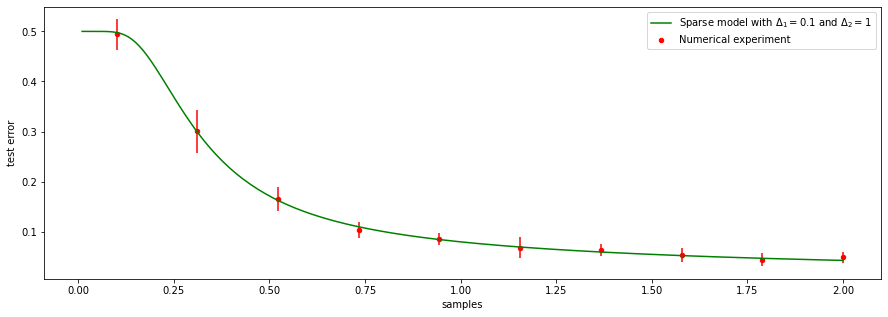

In [105]:
fig, ax = plt.subplots(figsize=(15,5))
ax=MyPredictor.get_curve().plot(x='sample_complexity', 
        y='test_error', 
        ax=ax, color='green',
        label=label)
ax=experiment.plot(x='sample_complexity', 
        y='test_error', 
        kind = 'scatter',
        yerr='test_error_std',
        ax=ax, color='red',
        label='Numerical experiment')
plt.ylabel(r"test error")
plt.xlabel(r"samples")
plt.legend()